In [1]:
import time
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

In [2]:
SAVE_PATH = "./figures"

In [3]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve_fixed_load(L, a, b, metric):

    try: 
        warnings.simplefilter("error")
        if not check_feasibility(L, a, b):
            raise ValueError("infeasible")

        x = cp.Variable(len(a))

        if (metric == "sw") or (metric == 0):
            objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        elif (metric == "pf") or (metric == 1):
            objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a, x) + b - L)))
        elif (metric == "mm") or (metric == float("inf")):
            objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        else:
            y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
            objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))

        constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver="CLARABEL")

        user_surplus = -0.5*a*x.value**2 + (b - L)*x.value
        surplus = np.sum(user_surplus)

        return problem.value, x.value, user_surplus, surplus, "success"
    
    except (Warning, cp.SolverError, TypeError, ValueError) as e:
        return np.nan, np.full(len(a), np.nan), np.full(len(a), np.nan), np.nan, str(e)


def solve(a, b, metric):
    pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
    results = pool.map(partial(solve_fixed_load, a=a, b=b, metric=metric), np.arange(0.1, 100, 0.1))
    results = [x for x in results if not np.isnan(x[0])]
    pool.close()
    return sorted(results, key=lambda x: -x[0])[0]


def solve_wrapper(params):
    
    seed = params["seed"]
    n_users = params["n_users"]
    metric = params["metric"]
    xbar = params["xbar"]
    
    np.random.seed(seed)
    
    a1 = 1*np.random.rand(n_users) + 1
    b1 = xbar * a1
    
    a2 = 1*np.random.rand(n_users) + 2
    b2 = xbar * a2
    
    a = np.append(a1, a2)
    b = np.append(b1, b2)

    val, sol, user_surplus, surplus, message = solve(a, b, metric)
        
    return dict(
        n_users=2*n_users, seed=seed, metric=metric, message=message,
        a=a, b=b, val=val, sol=sol, user_surplus=user_surplus,
        sol0=sol[:n_users], sol1=sol[n_users:],
        surplus0=user_surplus[:n_users],
        surplus1=user_surplus[n_users:],
    )

In [3]:
%%time

params_list = [
    dict(n_users=n_users, seed=seed, metric=metric, xbar=5)
    for n_users in [10] for seed in range(1000)
    for metric in ["sw", "pf", "mm"]
]

results = [solve_wrapper(params) for params in tqdm.tqdm(params_list)]
df = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [31:12<00:00,  1.60it/s]

CPU times: user 5min 39s, sys: 19min 35s, total: 25min 14s
Wall time: 31min 12s


In [5]:
df["a_rank"] = df.a.apply(lambda x: list(pd.Series(x).rank()))
df_sw = df.loc[df.metric=="sw"]
df_pf = df.loc[df.metric=="pf"]

a = np.array(df_sw.a.tolist())
a1 = a[:,:10]
a2 = a[:,10:]

rel_a1 = (a1 / a.max(1, keepdims=True)).flatten()
rel_a2 = (a2 / a.max(1, keepdims=True)).flatten()

sw_sol = np.array(df_sw.sol.tolist())
sw_sol1 = sw_sol[:,:10].flatten()
sw_sol2 = sw_sol[:,10:].flatten()

sw_user_surplus = np.array(df_sw.user_surplus.tolist())
sw_surplus1 = sw_user_surplus[:,:10].flatten()
sw_surplus2 = sw_user_surplus[:,10:].flatten()

pf_sol = np.array(df_pf.sol.tolist())
pf_sol1 = pf_sol[:,:10].flatten()
pf_sol2 = pf_sol[:,10:].flatten()

pf_user_surplus = np.array(df_pf.user_surplus.tolist())
pf_surplus1 = pf_user_surplus[:,:10].flatten()
pf_surplus2 = pf_user_surplus[:,10:].flatten()

## Figure 4

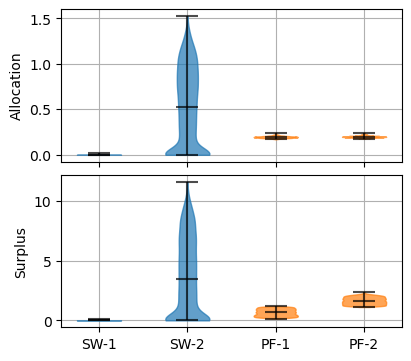

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3.5), constrained_layout=True)

# calculate price of fairness
ax = axs[0].violinplot([sw_sol1, sw_sol2, pf_sol1, pf_sol2], showmedians=True)
for i, pc in enumerate(ax["bodies"]):
    pc.set_facecolor(f"C{i//2}")
    pc.set_edgecolor(f"C{i//2}")
    pc.set_alpha(0.7)
    
for partname in ["cmedians", "cmins", "cmaxes", "cbars"]:
    vp = ax[partname]
    vp.set_edgecolor("k")
    vp.set_alpha(0.7)
    
axs[0].set_ylabel("Allocation")
axs[0].set_xticks([1, 2, 3, 4], [])
axs[0].set_axisbelow(True)
axs[0].grid(zorder=0)

# calculate price of efficiency
ax = axs[1].violinplot([sw_surplus1, sw_surplus2, pf_surplus1, pf_surplus2], showmedians=True)
for i, pc in enumerate(ax["bodies"]):
    pc.set_facecolor(f"C{i//2}")
    pc.set_edgecolor(f"C{i//2}")
    pc.set_alpha(0.7)
    
for partname in ["cmedians", "cmins", "cmaxes", "cbars"]:
    vp = ax[partname]
    vp.set_edgecolor("k")
    vp.set_alpha(0.7)
    
axs[1].set_ylabel("Surplus")
axs[1].set_xticks([1, 2, 3, 4], ["SW-1", "SW-2", "PF-1", "PF-2"])
axs[1].set_axisbelow(True)
axs[1].grid(zorder=0)


plt.savefig(f"{SAVE_PATH}/two-class-small.png", dpi=300)
plt.show()

## Figure 5

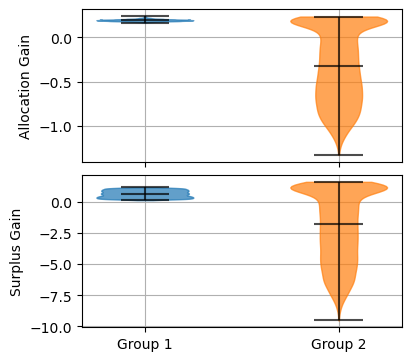

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3.5), constrained_layout=True)

# calculate price of fairness
ax = axs[0].violinplot([pf_sol1 - sw_sol1, pf_sol2 - sw_sol2], showmedians=True)
for i, pc in enumerate(ax["bodies"]):
    pc.set_facecolor(f"C{i}")
    pc.set_edgecolor(f"C{i}")
    pc.set_alpha(0.7)
    
for partname in ["cmedians", "cmins", "cmaxes", "cbars"]:
    vp = ax[partname]
    vp.set_edgecolor("k")
    vp.set_alpha(0.7)
    
axs[0].set_ylabel("Allocation Gain")
axs[0].set_xticks([1, 2], [])
axs[0].set_axisbelow(True)
axs[0].grid(zorder=0)

# calculate price of efficiency
ax = axs[1].violinplot([pf_surplus1 - sw_surplus1, pf_surplus2 - sw_surplus2], showmedians=True)
for i, pc in enumerate(ax["bodies"]):
    pc.set_facecolor(f"C{i}")
    pc.set_edgecolor(f"C{i}")
    pc.set_alpha(0.7)
    
for partname in ["cmedians", "cmins", "cmaxes", "cbars"]:
    vp = ax[partname]
    vp.set_edgecolor("k")
    vp.set_alpha(0.7)
    
axs[1].set_ylabel("Surplus Gain")
axs[1].set_xticks([1, 2], ["Group 1", "Group 2"])
axs[1].set_axisbelow(True)
axs[1].grid(zorder=0)

plt.savefig(f"{SAVE_PATH}/two-class-gain-small.png", dpi=300)
plt.show()